In [1]:
run ../initialize.ipynb

Lax Version : 1.5.2


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/seaborn-0.8.1-py3.4.egg/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
import scipy

In [3]:
def get_file_list(path, pattern, remove_string='', remove_path=True):
    '''
    Get a list of files matching pattern in path. Optional to remove a part of the path (i.e. the extention)
    Optional to remove the path
    '''
    file_list = glob.glob(path + pattern)
    # Remove path
    for i, f in enumerate(file_list):
        if remove_path:
            f = f.replace(path, '')
        if remove_string != '':
            f = f.replace(remove_string, '')
        file_list[i] = f
    file_list = np.sort(file_list)
    return file_list


### Find and load SR1 Datasets

In [4]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning', 'flash',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']


Processed data available selection: 0 rows removed (100.00% passed)
Source in place selection: 7229 rows removed (4.56% passed)
Source in place selection: 1185 rows removed (84.35% passed)
Source in place selection: 7119 rows removed (6.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [5]:
%%time
print('Searching for Processed Pickle Files')
#simpath= '/project/lgrandi/jpienaar/cache_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*dt.pkl', ' ')
print('Found %d datasets' % len(datasets))

processed_list=[]
for dataset in tqdm(datasets):
    with open(simpath+dataset, 'rb') as handle:
        data_temp = pickle.load(handle)
        try:
            data_temp['version']
            processed_list.append(dataset)
        except KeyError:
            continue
print("Found %i processed files " %len(processed_list))
datasets=processed_list

dicts_datasets_rn={}
duration_rn=0
events_rn=0
dicts_datasets_kr={}
duration_kr=0
events_kr=0
dicts_datasets_bkg={}
duration_bkg=0
events_bkg=0
for dataset in tqdm(datasets[:]):
    key=dataset[:-7]
    if dataset_names_rn.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_rn.loc[datasets_rn.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_rn+=time_diff.iloc[0].seconds
            events_rn+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_rn[key]=data_dict
              
    elif dataset_names_kr.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_kr.loc[datasets_kr.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_kr+=time_diff.iloc[0].seconds
            events_kr+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_kr[key]=data_dict
        
    elif dataset_names_bkg.isin([dataset[:-7]]).any():
        with open(simpath+dataset, 'rb') as handle:
            data_dict = pickle.load(handle)
            dataset_temp = datasets_bkg.loc[datasets_bkg.name==dataset[:-7]]
            time_diff=dataset_temp.end-dataset_temp.start
            data_dict['duration'] =  time_diff.iloc[0].seconds
            duration_bkg+=time_diff.iloc[0].seconds
            events_bkg+=dataset_temp.iloc[0].trigger__events_built
        dicts_datasets_bkg[key]=data_dict
    
#df_PI=pd.concat(df_PI)

  0%|          | 0/5707 [00:00<?, ?it/s]

Searching for Processed Pickle Files
Found 5707 datasets


  2%|▏         | 98/5541 [00:00<00:05, 978.23it/s]

Found 5541 processed files 


100%|██████████| 5541/5541 [03:56<00:00, 23.47it/s]  

CPU times: user 1min 24s, sys: 1min 27s, total: 2min 51s
Wall time: 12min 37s


In [6]:
print("Event Rate Radon:", events_rn/duration_rn)
print("Event Rate Krypton:", events_kr/duration_kr)
print("Event Rate Background:", events_bkg/duration_bkg)

Event Rate Radon: 28.9232782606
Event Rate Krypton: 52.7182158711
Event Rate Background: 5.83930826463


In [8]:
dict_source_sr1={'Radon' : dicts_datasets_rn, 'Background' : dicts_datasets_bkg, 'Krypton': dicts_datasets_kr,}
for source, dict_data in dict_source_sr1.items():
    print(source, len(dict_data))

Radon 200
Krypton 174
Background 2020


### Make 1d Histograms of Initial S2 Size

Radon 200
Event Rate: 18.76


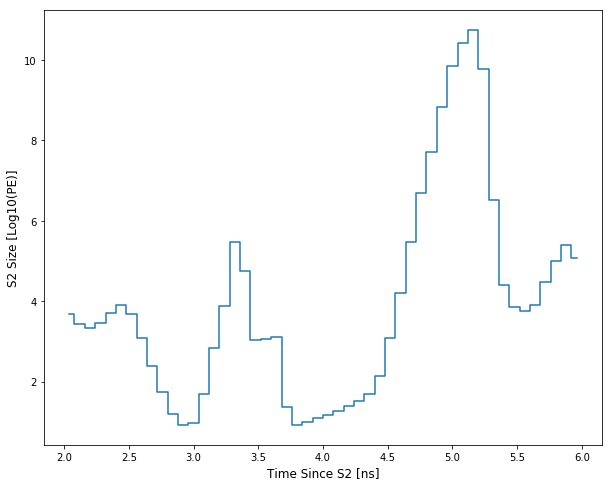

Krypton 174
Event Rate: 21.60


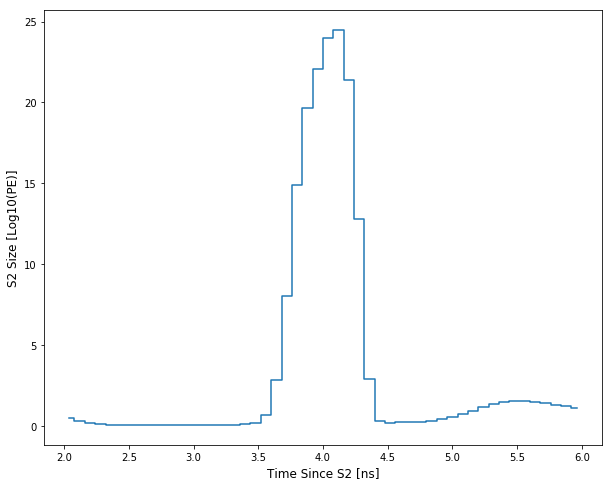

Background 2020
Event Rate: 1.09


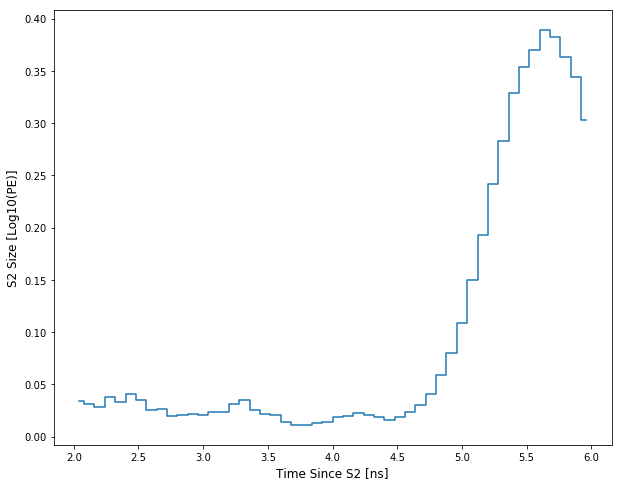

In [10]:
##Live Time Corrected 2d Plots##
#plt.figure(figsize=(10, 8))
index=0
_xmax=10**8
_tpoints=np.linspace(0, _xmax, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
livet_hist=0
events=0
plt.set_cmap("Oranges")

_s2bins=50
_tbins=200
sampling_dict={}
events_hist=0
for source, dict_data in dict_source_sr1.items():
    print(source, len(dict_data))
    plt.figure(figsize=(10, 8))
    del events_hist
    #del livet_hist
    events=0
    duration=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            events+=data['events']
            duration+=data['duration']
        except NameError:
            events_hist=data['deltat']
            events=data['events']
            duration=data['duration']
    
      
                
    print("Event Rate: %.2f" %(events/duration))
    
    events_hist=events_hist.sum("delta_T")
    events_hist.plot()    
    plt.xlabel('Time Since S2 [ns]', fontsize=12)
    plt.ylabel('S2 Size [Log10(PE)]', fontsize=12)
    #plt.savefig("fig_%s_2d_rate_corrected.png" %source, bboxes='tight')
    #plt.savefig("fig_%s_2d_rate_corrected.pdf" %source, bboxes='tight')
    plt.show()    

    sampling_dict[source]={'hist': events_hist, 'event_rate' :events/duration} 
    
   
    #new_hist.plot(label=source, color=colours[index])
    #index+=1


In [211]:
with open('s2_spectrum_per_source_sr1.pkl', 'wb') as handle:
    pickle.dump(sampling_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### 1D Rate Histograms

Radon
13428205
Krypton
13457032
Background
7840222


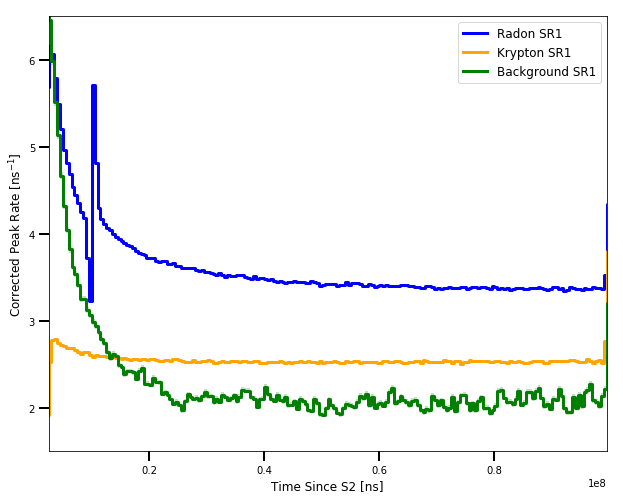

In [13]:
#Plots corrected event with error added#
colours=['blue', 'orange', 'green', 'magenta', 'cyan', 'red']
plt.figure(figsize=(10, 8))
index=0
window_length=10**8
_tpoints=np.linspace(0, window_length, 201)
_xmin=_tpoints[1]
_ymax=1.7e-7
events_hist=0
events=0
index=0

data_hists_dict={}
for source, dict_data in dict_source_sr1.items():
    print(source)
    del events_hist
    del livet_hist
    events=0
    for key, data in dict_data.items():
        try:
            events_hist
            events_hist+=data['deltat']
            weight_hist+=data['deltat_weights']
            livet_hist+=data['livet_hist']
            livet_weight+=data['livet_weights']
            events+=data['events']
        except NameError:
            events_hist=data['deltat']
            weight_hist=data['deltat_weights']
            livet_hist=data['livet_hist']
            livet_weight=data['livet_weights']
            events=data['events']
        except KeyError:
            print(source, key)
        
    events_hist=events_hist.sum('s2_area')
    weight_hist=weight_hist.sum('s2_area')
    livet_hist=livet_hist.sum('s2_area')
    livet_weight=livet_weight.sum('s2_area')
    
    #Error
    num_value=np.array(events_hist)
    denum_value=np.array(livet_hist)
    num_error = np.sqrt(weight_hist)
    denum_error = np.sqrt(livet_weight)
    e1 = num_error
    e2 = denum_error
    b1 = num_value
    b2 = denum_value
    w=b1/b2
    
    ratio_error = np.abs(((1-2*w)*e1*e1 + w*w*e2*e2)/(b2*b2))       
    ratio = num_value/denum_value 
    
    #Confidence Bands
    x = _tpoints
    x = np.sort(np.array(list(x[1:]) + list(x[:-1])))
    y1=ratio-np.sqrt(ratio_error)
    y2=ratio+np.sqrt(ratio_error)
    y_lower = np.repeat(y1[:], 2)
    y_upper = np.repeat(y2[:], 2)
        
    #Plot
    plt.step(_tpoints[1:], ratio*1000000, linewidth=3,  color=colours[index], label=source+' SR1')
    plt.fill_between(x, y_lower*1000000, y_upper*1000000, facecolor=colours[index], interpolate=True, alpha = 0.25)
    index+=1
    data_hists_dict[source] = {'rate' : ratio*1000000, 'lower' : y_lower*1000000, 'upeer' : y_upper*1000000}
    print(events)

plt.xlim([_tpoints[5], _tpoints[-2]])
plt.ylim([1.5, 6.5])
plt.xlabel('Time Since S2 [ns]', fontsize=12)
plt.ylabel('Corrected Peak Rate [ns$^{-1}$]', fontsize=12)
axes = plt.gca()
axes.tick_params(width=2, length=10)
plt.legend(loc='best', fontsize=12)
#plt.yscale('log')
plt.show()

### Organize thoughts

Options.)

- No uniform background, only dealyed extraction
- Uniform SE background plus delayed extraction

#Scale bins by bin_size


In [14]:
#Load S2 size histograms:
with open('s2_spectrum_per_source_sr1.pkl', 'rb') as handle:
    sampling_dict = pickle.load(handle)

In [72]:
def rate_function(scaling_constant, time_scale, dt_bins):
    y = scaling_constant*np.exp(-dt_bins/time_scale)
    return (y)


def se_histogram(event_rate, # Number of events assumed to occur within 1s
                 background_rate, # Flat background rate of Single Electrons 
                 time_scale, # Time Scale of exponential decay of trapped electrons
                 scaling_constant, #Fraction of electrons relative to S2 size 
                 source = 'Background', # Primary S2 spectrum for sampling from
                 time_bins=100, # Number of bins in time
                 window_length=1000 #Length after given S2 to look at
                ):
    
    #Determine number of events in timw window
    number_of_events = np.random.poisson(event_rate) #Event rate in window....
    
    #Assign random times to S2s in window following S2, leaving first S2 at t=0 
    if number_of_events>1:
        time_of_s2s=np.random.random(number_of_events-1)
        time_of_s2s=np.concatenate(([0], time_of_s2s))
    else:
        number_of_events = 1
        time_of_s2s=np.array([0])
    
    bin_width=window_length/time_bins
    
    #Sample from Appropriate S2 Size Spectrum (produced previously)
    s2_spectrum_hist = sampling_dict[source]['hist']    
    s2_size = np.random.choice(s2_spectrum_hist.bin_centers, 
                               number_of_events, 
                               p =(s2_spectrum_hist[:])/np.sum(s2_spectrum_hist[:]))
    s2_size=10**s2_size
    
    #Initialize Arrays of SE rate
    se_rate=[background_rate]*time_bins
    dt_bins=np.linspace(0, window_length, time_bins+1)
    
    #print(s2_size)
    
    for is2, s2 in enumerate(time_of_s2s):
        s2 = s2 * window_length # Span window length, assumed to be in ms
        bin_offset = np.digitize(s2, dt_bins) 
        counts = rate_function(scaling_constant = scaling_constant*s2_size[is2], 
                               time_scale=time_scale, 
                               dt_bins=dt_bins)
        event_len =  time_bins-bin_offset
        zero_array = np.array([0]*int(bin_offset))
        counts = np.concatenate((np.array(zero_array), counts[:event_len]))
        se_rate += counts
    
    dt_bin_centers = dt_bins[1:]-(dt_bins[1:]-dt_bins[:-1])/2
    
    return dt_bin_centers, se_rate
        
        
    
    

100%|██████████| 1000/1000 [00:00<00:00, 6533.15it/s]


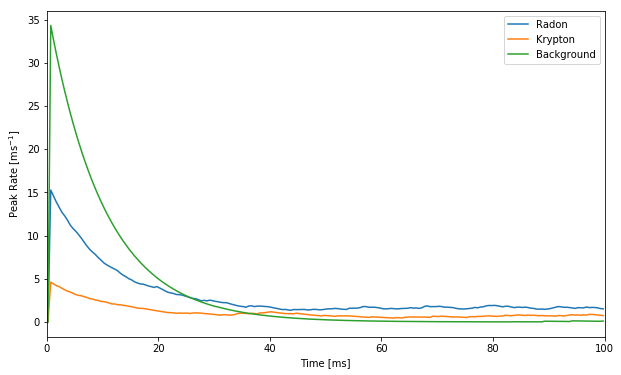

In [92]:
fig = plt.figure(figsize=(10, 6))

waveforms = 1000
time_bins = 200
window_length=100

for source, hist_dict in sampling_dict.items():
    
    x_bins = [0]*time_bins
    y_bins = [0]*time_bins
    
    source_rate = hist_dict['event_rate']

    event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms
    
    for sim in tqdm(range(waveforms)):
        dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=0, 
                                               time_scale = 10,
                                               scaling_constant = 0.0001, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
        y_bins += se_rate
    x_bins = dt_bin_centers 
    plt.plot(x_bins, y_bins/waveforms, label=source)
plt.ylabel("Peak Rate [ms$^{-1}$]")
plt.xlabel("Time [ms]")
plt.xlim([0, window_length])
plt.legend(loc='best')

100%|██████████| 10000/10000 [00:02<00:00, 3854.04it/s]


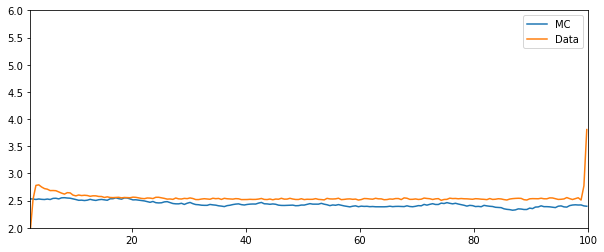

In [128]:
fig = plt.figure(figsize=(10, 4))
waveforms = 10000
time_bins = 200
window_length=100
x_bins = [0]*time_bins
y_bins = [0]*time_bins
source='Krypton'    
source_rate = 52.72
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms
    
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=0, 
                                               time_scale = 21.5,
                                               scaling_constant = 5.623e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
x_bins = dt_bin_centers 
plt.plot(x_bins, y_bins/waveforms, label='MC')
plt.plot(x_bins[4:], data_hists_dict[source]['rate'][4:], label='Data')
plt.legend()
plt.ylim([2,6])

plt.xlim([x_bins[4], 100])
plt.show()

100%|██████████| 10000/10000 [00:01<00:00, 5099.60it/s]


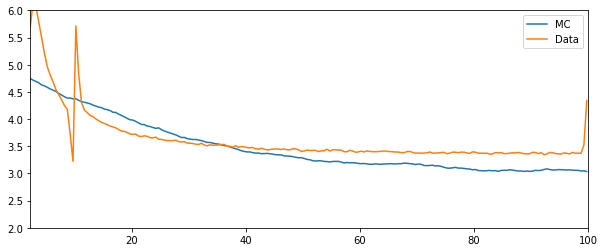

In [137]:
fig = plt.figure(figsize=(10, 4))
waveforms = 10000
time_bins = 200
window_length=100
x_bins = [0]*time_bins
y_bins = [0]*time_bins
source='Radon'    
source_rate = 28.92
event_rate = source_rate*window_length/1000 #Event rate in s, window length in ms
    
for sim in tqdm(range(waveforms)):
    dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                               background_rate=0, 
                                               time_scale = 31.6,
                                               scaling_constant = 3.162e-05, 
                                               
                                               source = source,
                                               time_bins=time_bins,
                                               window_length = window_length)
    y_bins += se_rate
x_bins = dt_bin_centers 
plt.plot(x_bins, y_bins/waveforms, label='MC')
plt.plot(x_bins[4:], data_hists_dict[source]['rate'][4:], label='Data')
plt.legend()
plt.ylim([2,6])

plt.xlim([x_bins[4], 100])
plt.show()

### Fit Data to ToyMC

Event Rate Radon: 28.9232782606
Event Rate Krypton: 52.7182158711
Event Rate Background: 5.83930826463

In [93]:
#Store fit values for parameter being scanned
scaling_constant_values=np.logspace(-6, -3, 25)
time_scale_values=np.logspace(0, 2, 25)
fit_values=[]
p_values=[]

#Settings for ToyMC for other parameters
time_bins=200 #Needed to match data
window_length=100 #Needed to match data
source='Background'
source_rate = 5.839
#source_rate = sampling_dict[source]['event_rate']
background_rate=1

#Rate from Data
rate_obs = data_hists_dict[source]['rate']

for  scaling_constant in tqdm(scaling_constant_values):
    temp_array=[]
    temp_p_array=[]
    for  time_scale in time_scale_values:
        #Initialize Bins
        x_bins = [0]*time_bins
        y_bins = [0]*time_bins

        #Run 1000 TImes
        event_rate = source_rate*window_length/1000
        for sim in range(waveforms):
            dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                    background_rate=background_rate, 
                                                    time_scale = time_scale,
                                                    scaling_constant = scaling_constant, 
                                                    source = source,
                                                    time_bins=time_bins,
                                                    window_length = 100)
            y_bins += se_rate/waveforms
        rate_exp = y_bins

        fit_value, fit_probability = scipy.stats.chisquare(rate_obs[4:], rate_exp[4:])
        temp_array = np.append(temp_array, fit_value)
        temp_p_array = np.append(temp_p_array, fit_probability)
    fit_values.append(temp_array)
    p_values.append(temp_p_array)
fit_values=np.array(fit_values)
p_values=np.array(p_values)

100%|██████████| 25/25 [01:22<00:00,  3.28s/it]


Best fit chisq value : 2.91018401522
Best fit p-value : 1.0
Best fit scaling constant : 5.6234132519e-05
Best time_scale constant : 21.5443469003


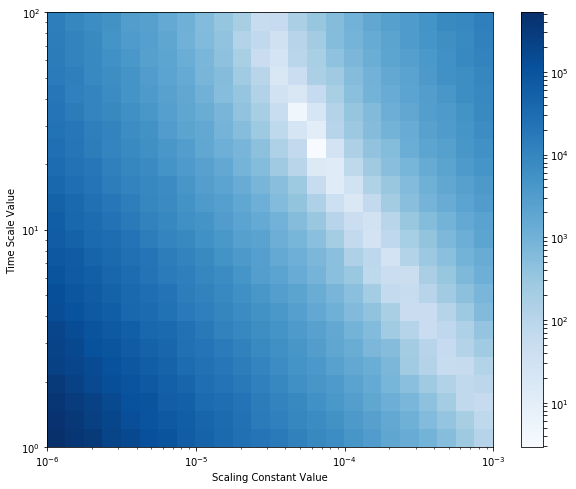

In [85]:
#Krypton
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, norm=LogNorm())
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")

Best fit chisq value : 9.62620678689
Best fit p-value : 1.0
Best fit scaling constant : 3.16227766017e-05
Best time_scale constant : 31.6227766017


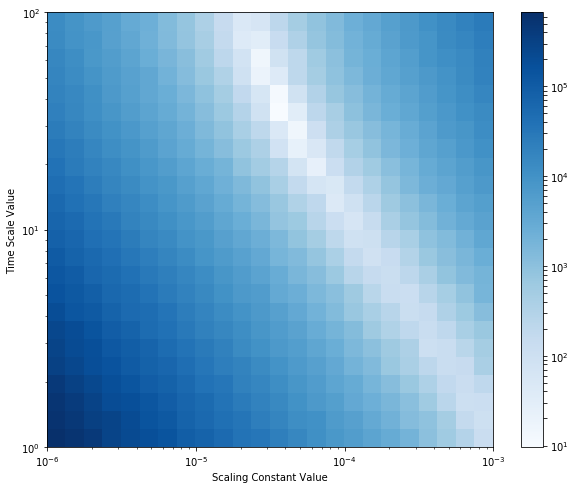

In [87]:
#Radon
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, norm=LogNorm())
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")

Best fit chisq value : 22.8988556874
Best fit p-value : 1.0
Best fit scaling constant : 7.49894209332e-06
Best time_scale constant : 56.234132519


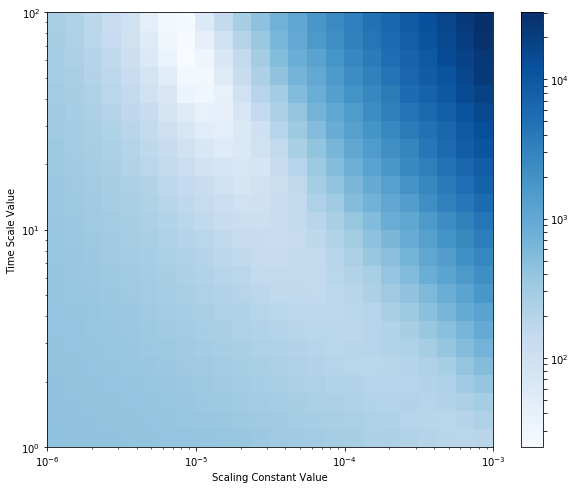

In [94]:
#Background
fig = plt.figure(figsize=(10, 8))
plt.set_cmap("Blues")
plt.pcolormesh(scaling_constant_values, time_scale_values, fit_values.T, norm=LogNorm())
i_min = np.unravel_index(fit_values.argmin(), fit_values.shape)
print("Best fit chisq value :",  fit_values[i_min[0]][i_min[1]])
print("Best fit p-value :",  p_values[i_min[0]][i_min[1]])
print("Best fit scaling constant :",  scaling_constant_values[i_min[0]])
print("Best time_scale constant :",  time_scale_values[i_min[1]])
plt.colorbar()
plt.yscale('log')
plt.xscale('log')
plt.xlabel("Scaling Constant Value")
plt.ylabel("Time Scale Value")


In [338]:
#Rate from Data
rate_obs = data_hists_dict['Background']['rate']

#Store fit values for parameter being scanned
time_scale_fits=[]
time_scale_values=np.logspace(-1, 2, 101)

#Settings for ToyMC for other parameters
time_bins=200
window_length=100
source_rate=50
source='Krypton'

for  time_scale in tqdm(time_scale_values):
    #Initialize Bins
    x_bins = [0]*time_bins
    y_bins = [0]*time_bins

    #Run 1000 TImes
    event_rate = source_rate*window_length/1000
    for sim in range(waveforms):
        dt_bin_centers, se_rate = se_histogram(event_rate = event_rate, 
                                                background_rate=0, 
                                                time_scale = time_scale,
                                                scaling_constant = 1, 
                                                source = source,
                                                time_bins=time_bins,
                                                window_length = 100)
        y_bins += se_rate/waveforms
    rate_exp = y_bins

    fit_value, fit_probability = scipy.stats.chisquare(rate_obs[4:], rate_exp[4:])
    time_scale_fits.append(fit_value)
    
print (fit_value, fit_probability)

100%|██████████| 101/101 [00:45<00:00,  2.20it/s]

1001.0789211 1.6513338886e-108


Best fit scaling constant : 11.7489755494


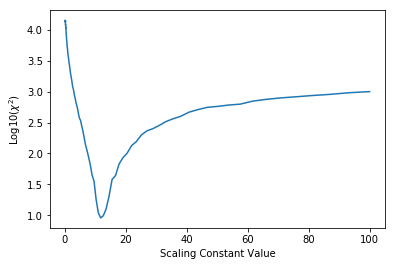

In [340]:
plt.plot(time_scale_values, np.log10(time_scale_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  time_scale_values[np.argmin(scaling_constant_fits)])

Best fit scaling constant : 0.954992586021


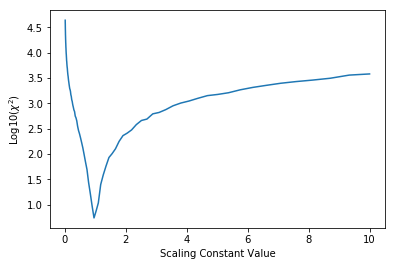

In [329]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])

Best fit scaling constant : 1.17489755494


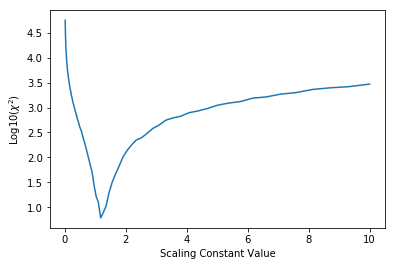

In [331]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])

Best fit scaling constant : 1.17489755494


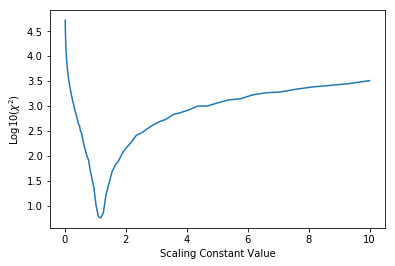

In [333]:
plt.plot(scaling_constant_values, np.log10(scaling_constant_fits))
plt.xlabel("Scaling Constant Value")
plt.ylabel("Log10($\chi^{2}$)")
print("Best fit scaling constant :",  scaling_constant_values[np.argmin(scaling_constant_fits)])